In [1]:
import importlib
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt

import utility_v1
import propagators_v1
import energy_landscapes_v1

import parallel_simulations_v1
import weighted_ensemble_v1
import metadynamics_v1
import multiple_walker_metadynamics_v1

import visualization_v1

#methods for fast print debugging #<---- these probably belong in utility_v1.py
def p(x):
    print(x)
def pl(x):
    print(len(x))
def ps(x):
    print(x.shape)

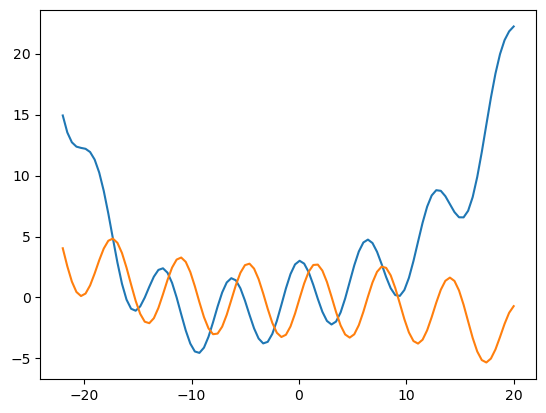

In [148]:
kT = 1
dt = 0.01

importlib.reload(energy_landscapes_v1)

system1 = energy_landscapes_v1.deep_sine_well()
system1.plot_quantity(system1.potential)
system1.plot_quantity(system1.F)
plt.show()



running 1500 parallel multiple walker metadynamics simulations for 100000 steps each
molecular time: 100000 steps;  aggregate time: 150000000 steps
data points saved: 300000.0 at 500-step intervals
gaussians of height 4.9999999999999996e-05 are added every 500 steps
[[-22], [20]]
[102]
bincenters [(-22.21,), (-21.79,), (-21.37,), (-20.95,), (-20.53,), (-20.11,), (-19.69,), (-19.27,), (-18.85,), (-18.43,), (-18.01,), (-17.59,), (-17.17,), (-16.75,), (-16.33,), (-15.91,), (-15.49,), (-15.07,), (-14.65,), (-14.23,), (-13.81,), (-13.39,), (-12.97,), (-12.55,), (-12.129999999999999,), (-11.709999999999999,), (-11.29,), (-10.87,), (-10.45,), (-10.03,), (-9.61,), (-9.19,), (-8.77,), (-8.35,), (-7.93,), (-7.51,), (-7.09,), (-6.67,), (-6.25,), (-5.829999999999998,), (-5.41,), (-4.989999999999998,), (-4.57,), (-4.149999999999999,), (-3.7300000000000004,), (-3.3099999999999987,), (-2.8900000000000006,), (-2.469999999999999,), (-2.049999999999997,), (-1.629999999999999,), (-1.2099999999999973,),

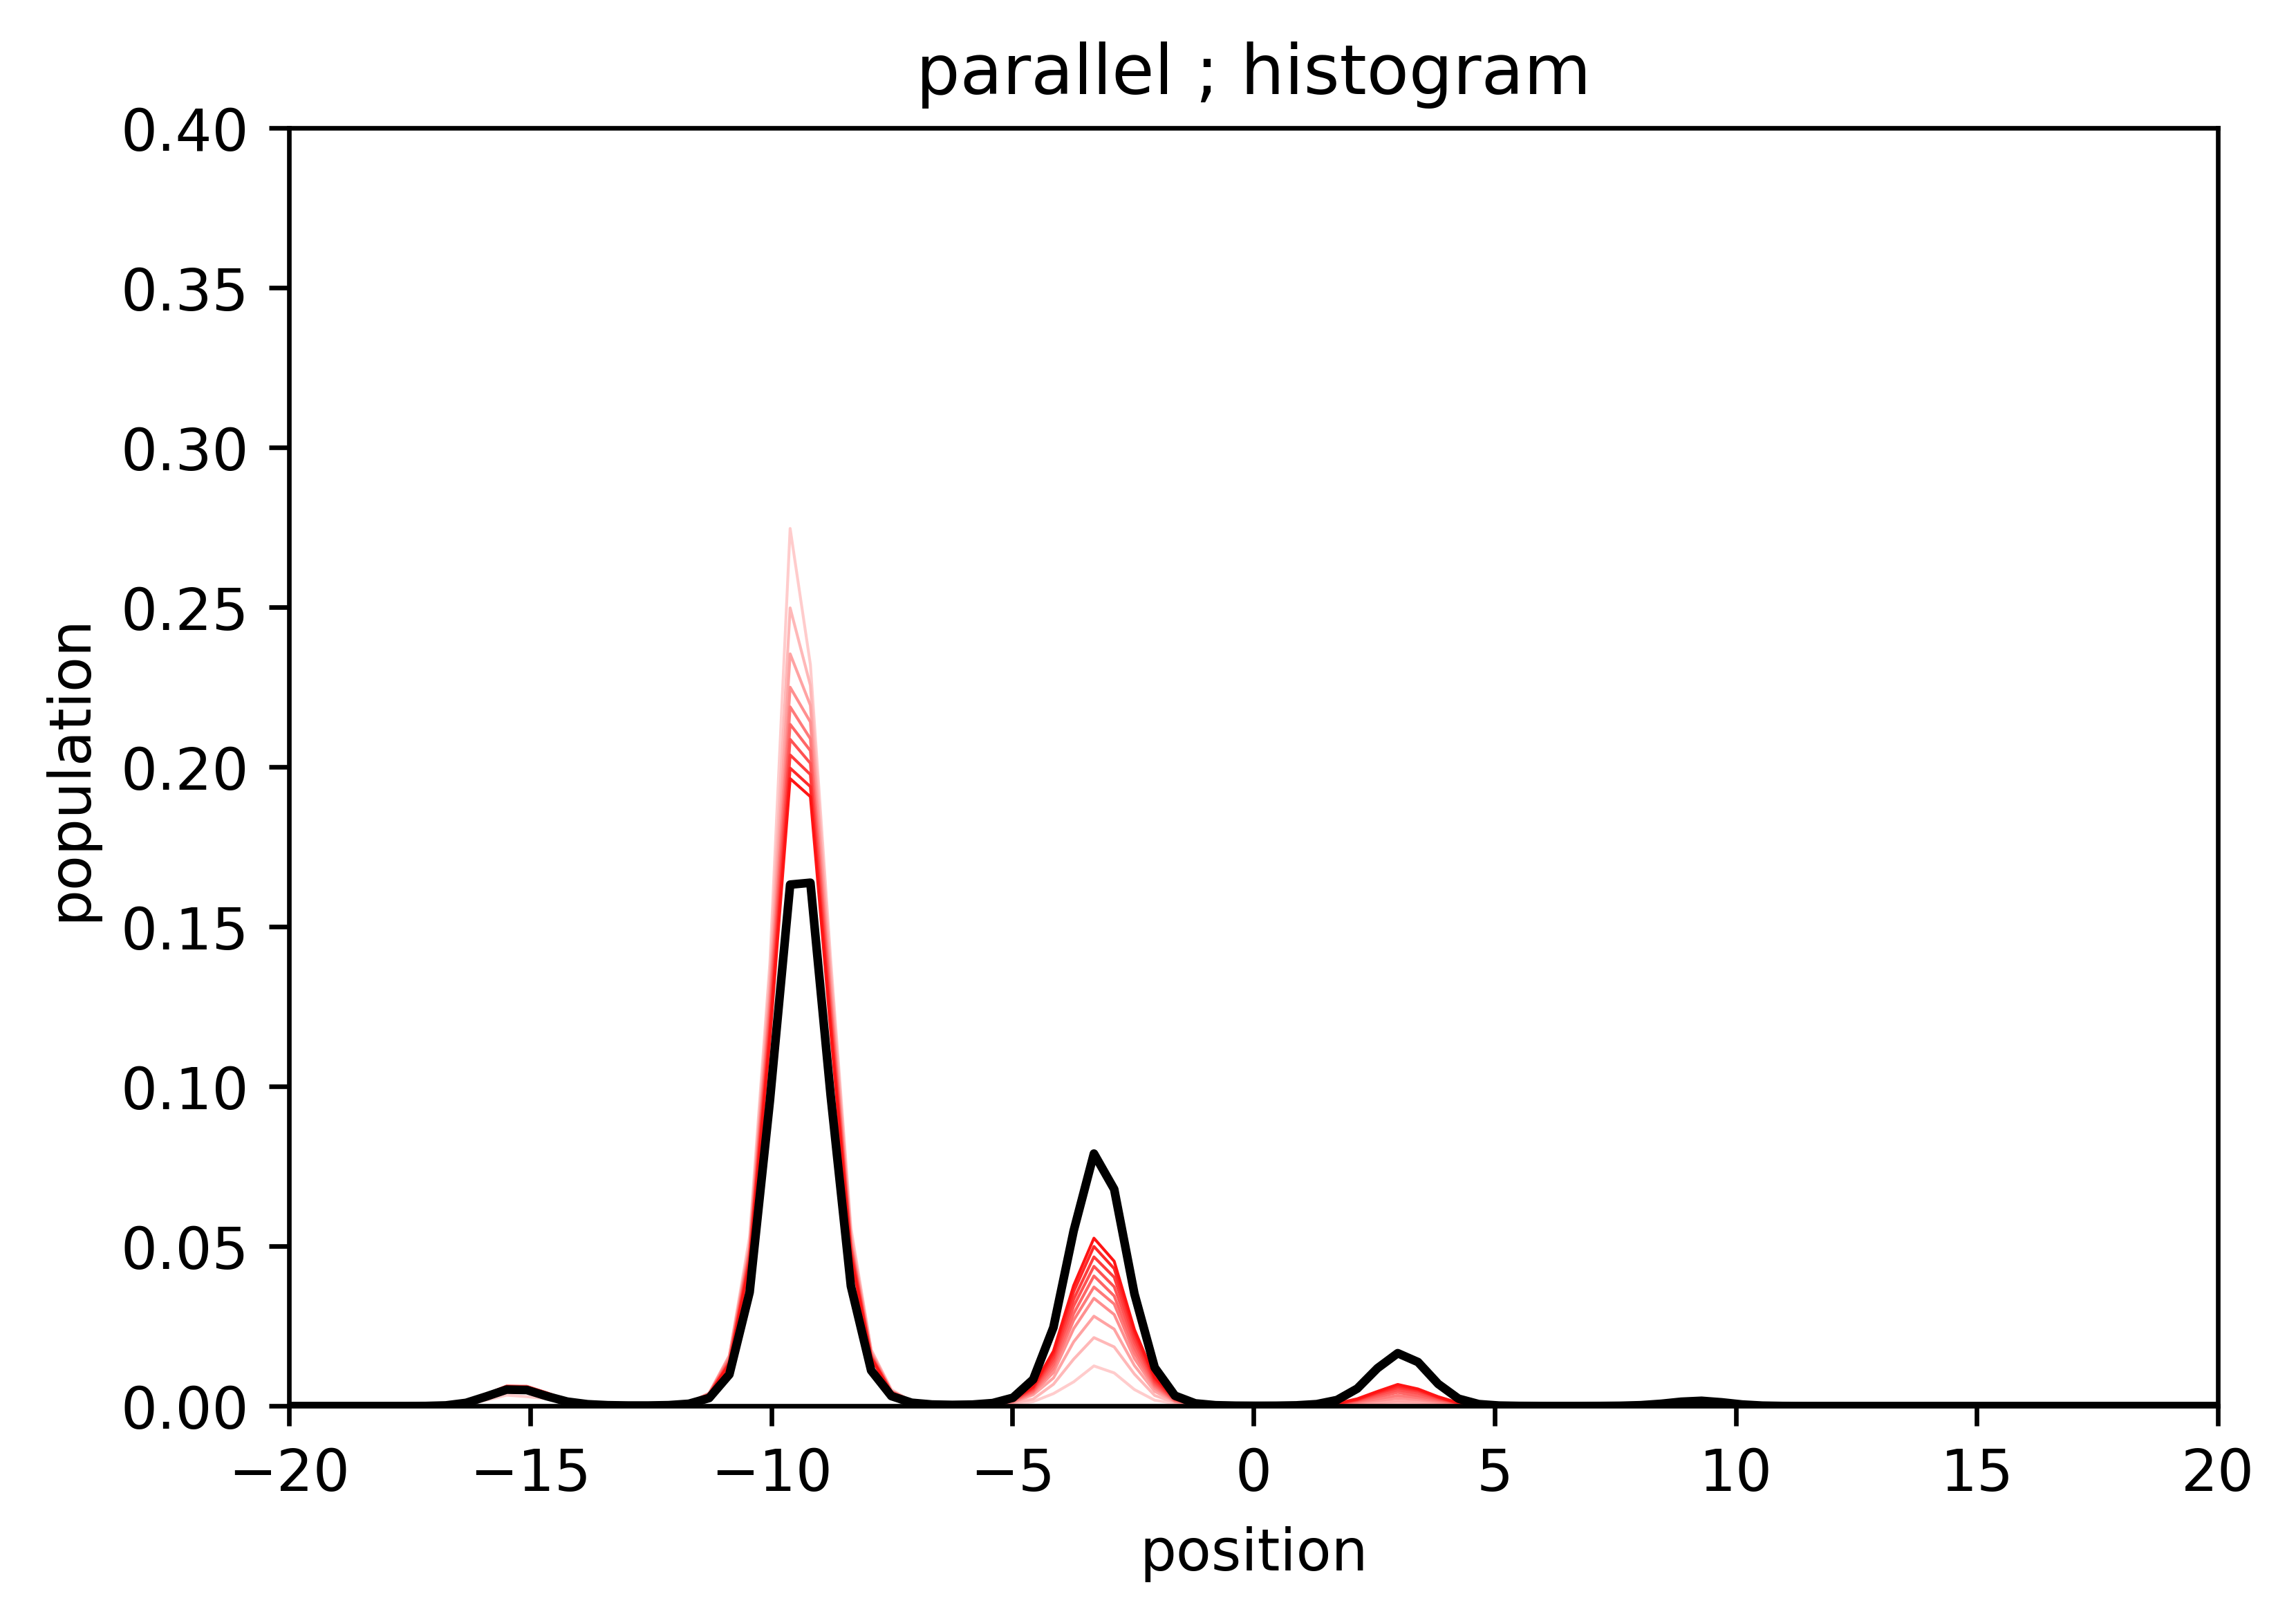

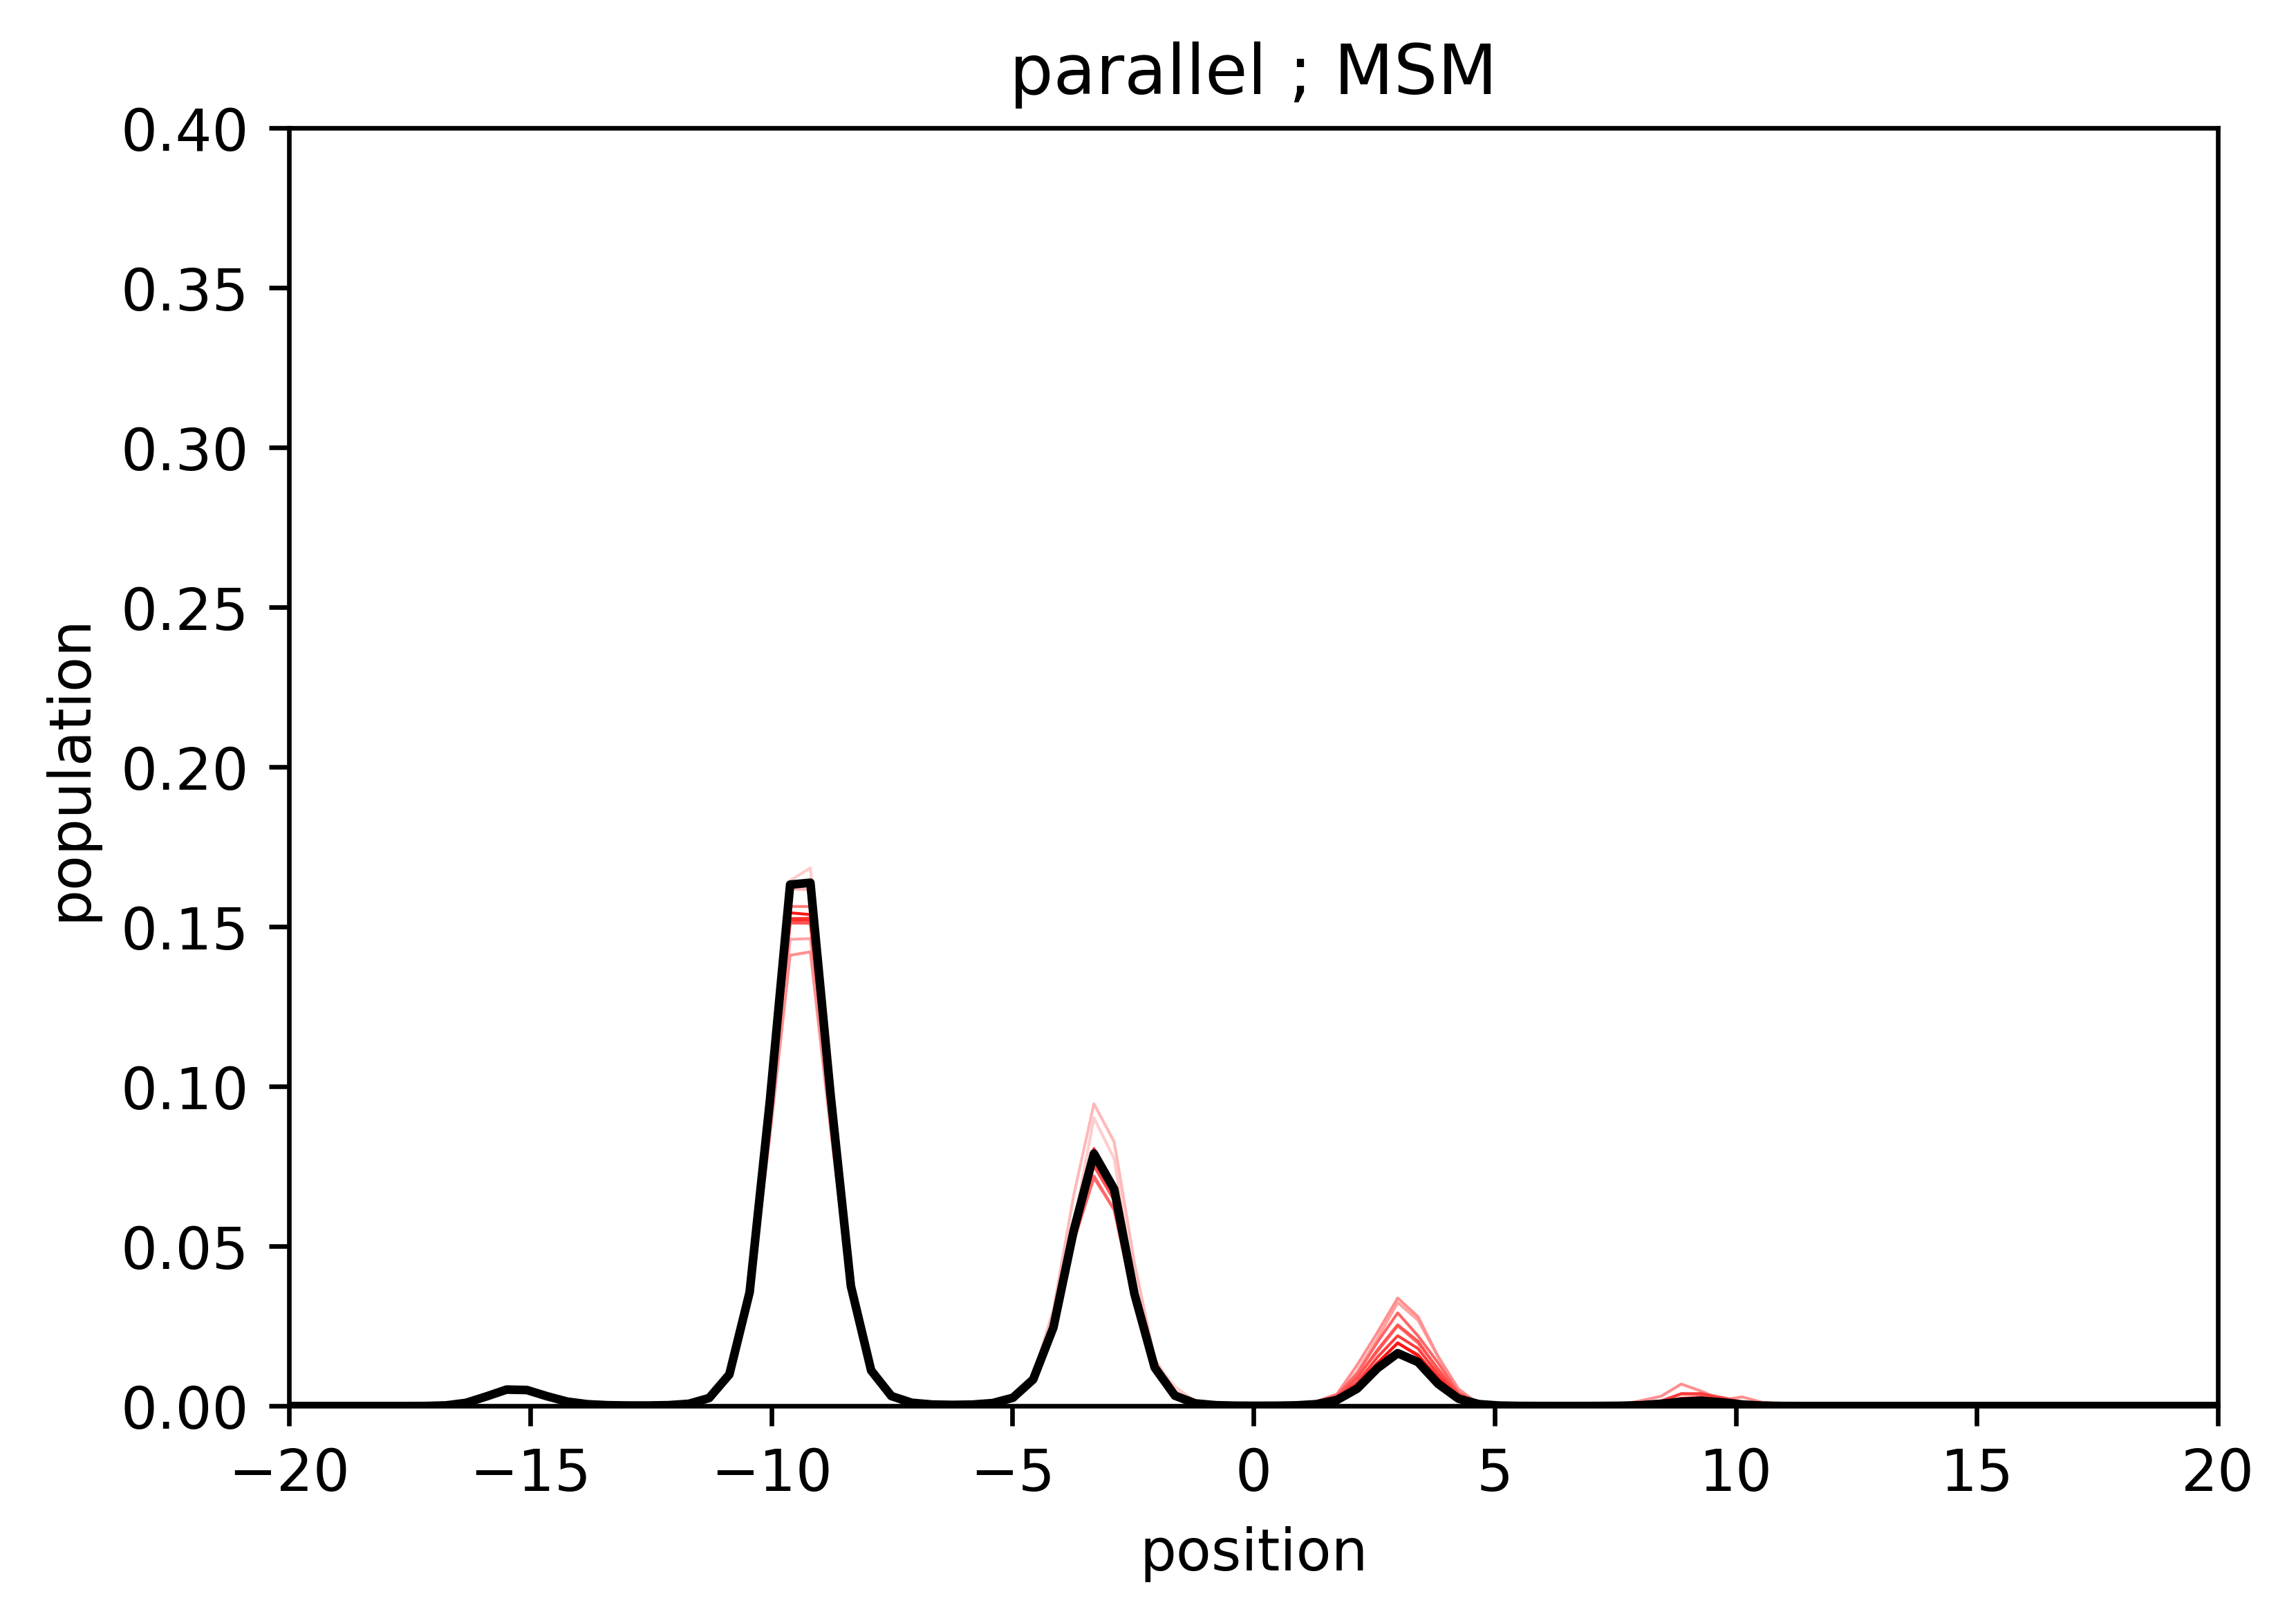

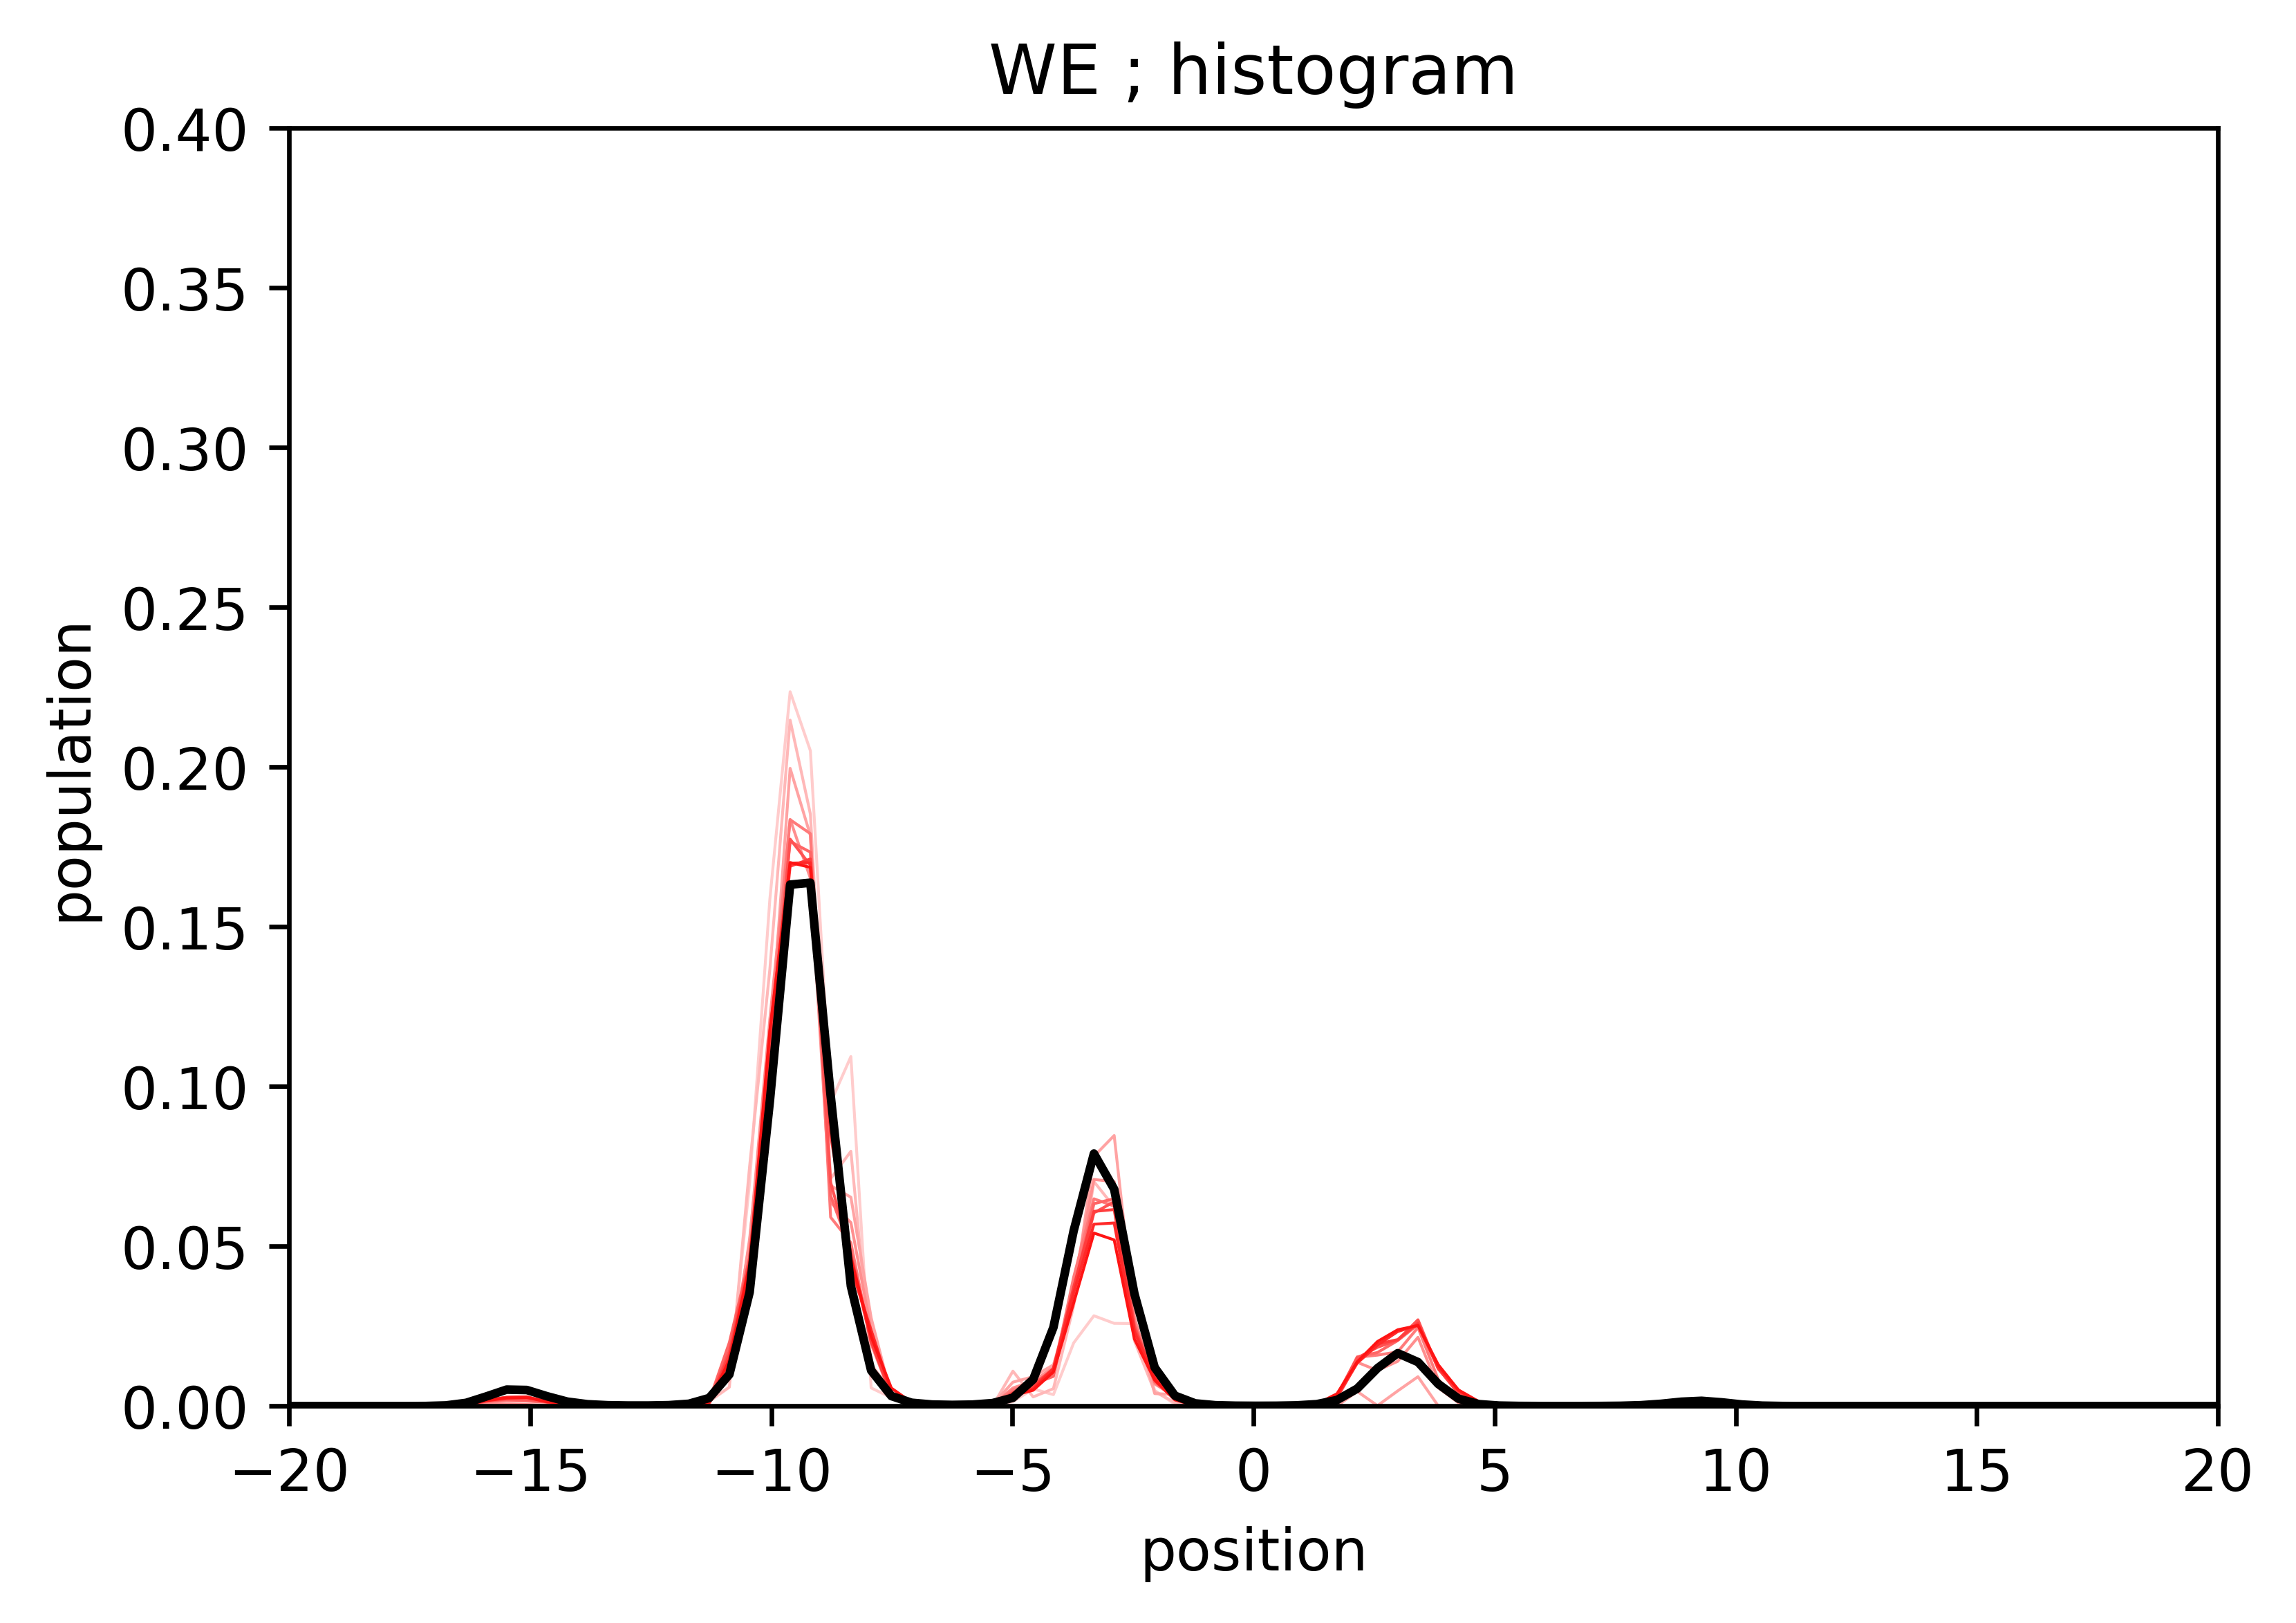

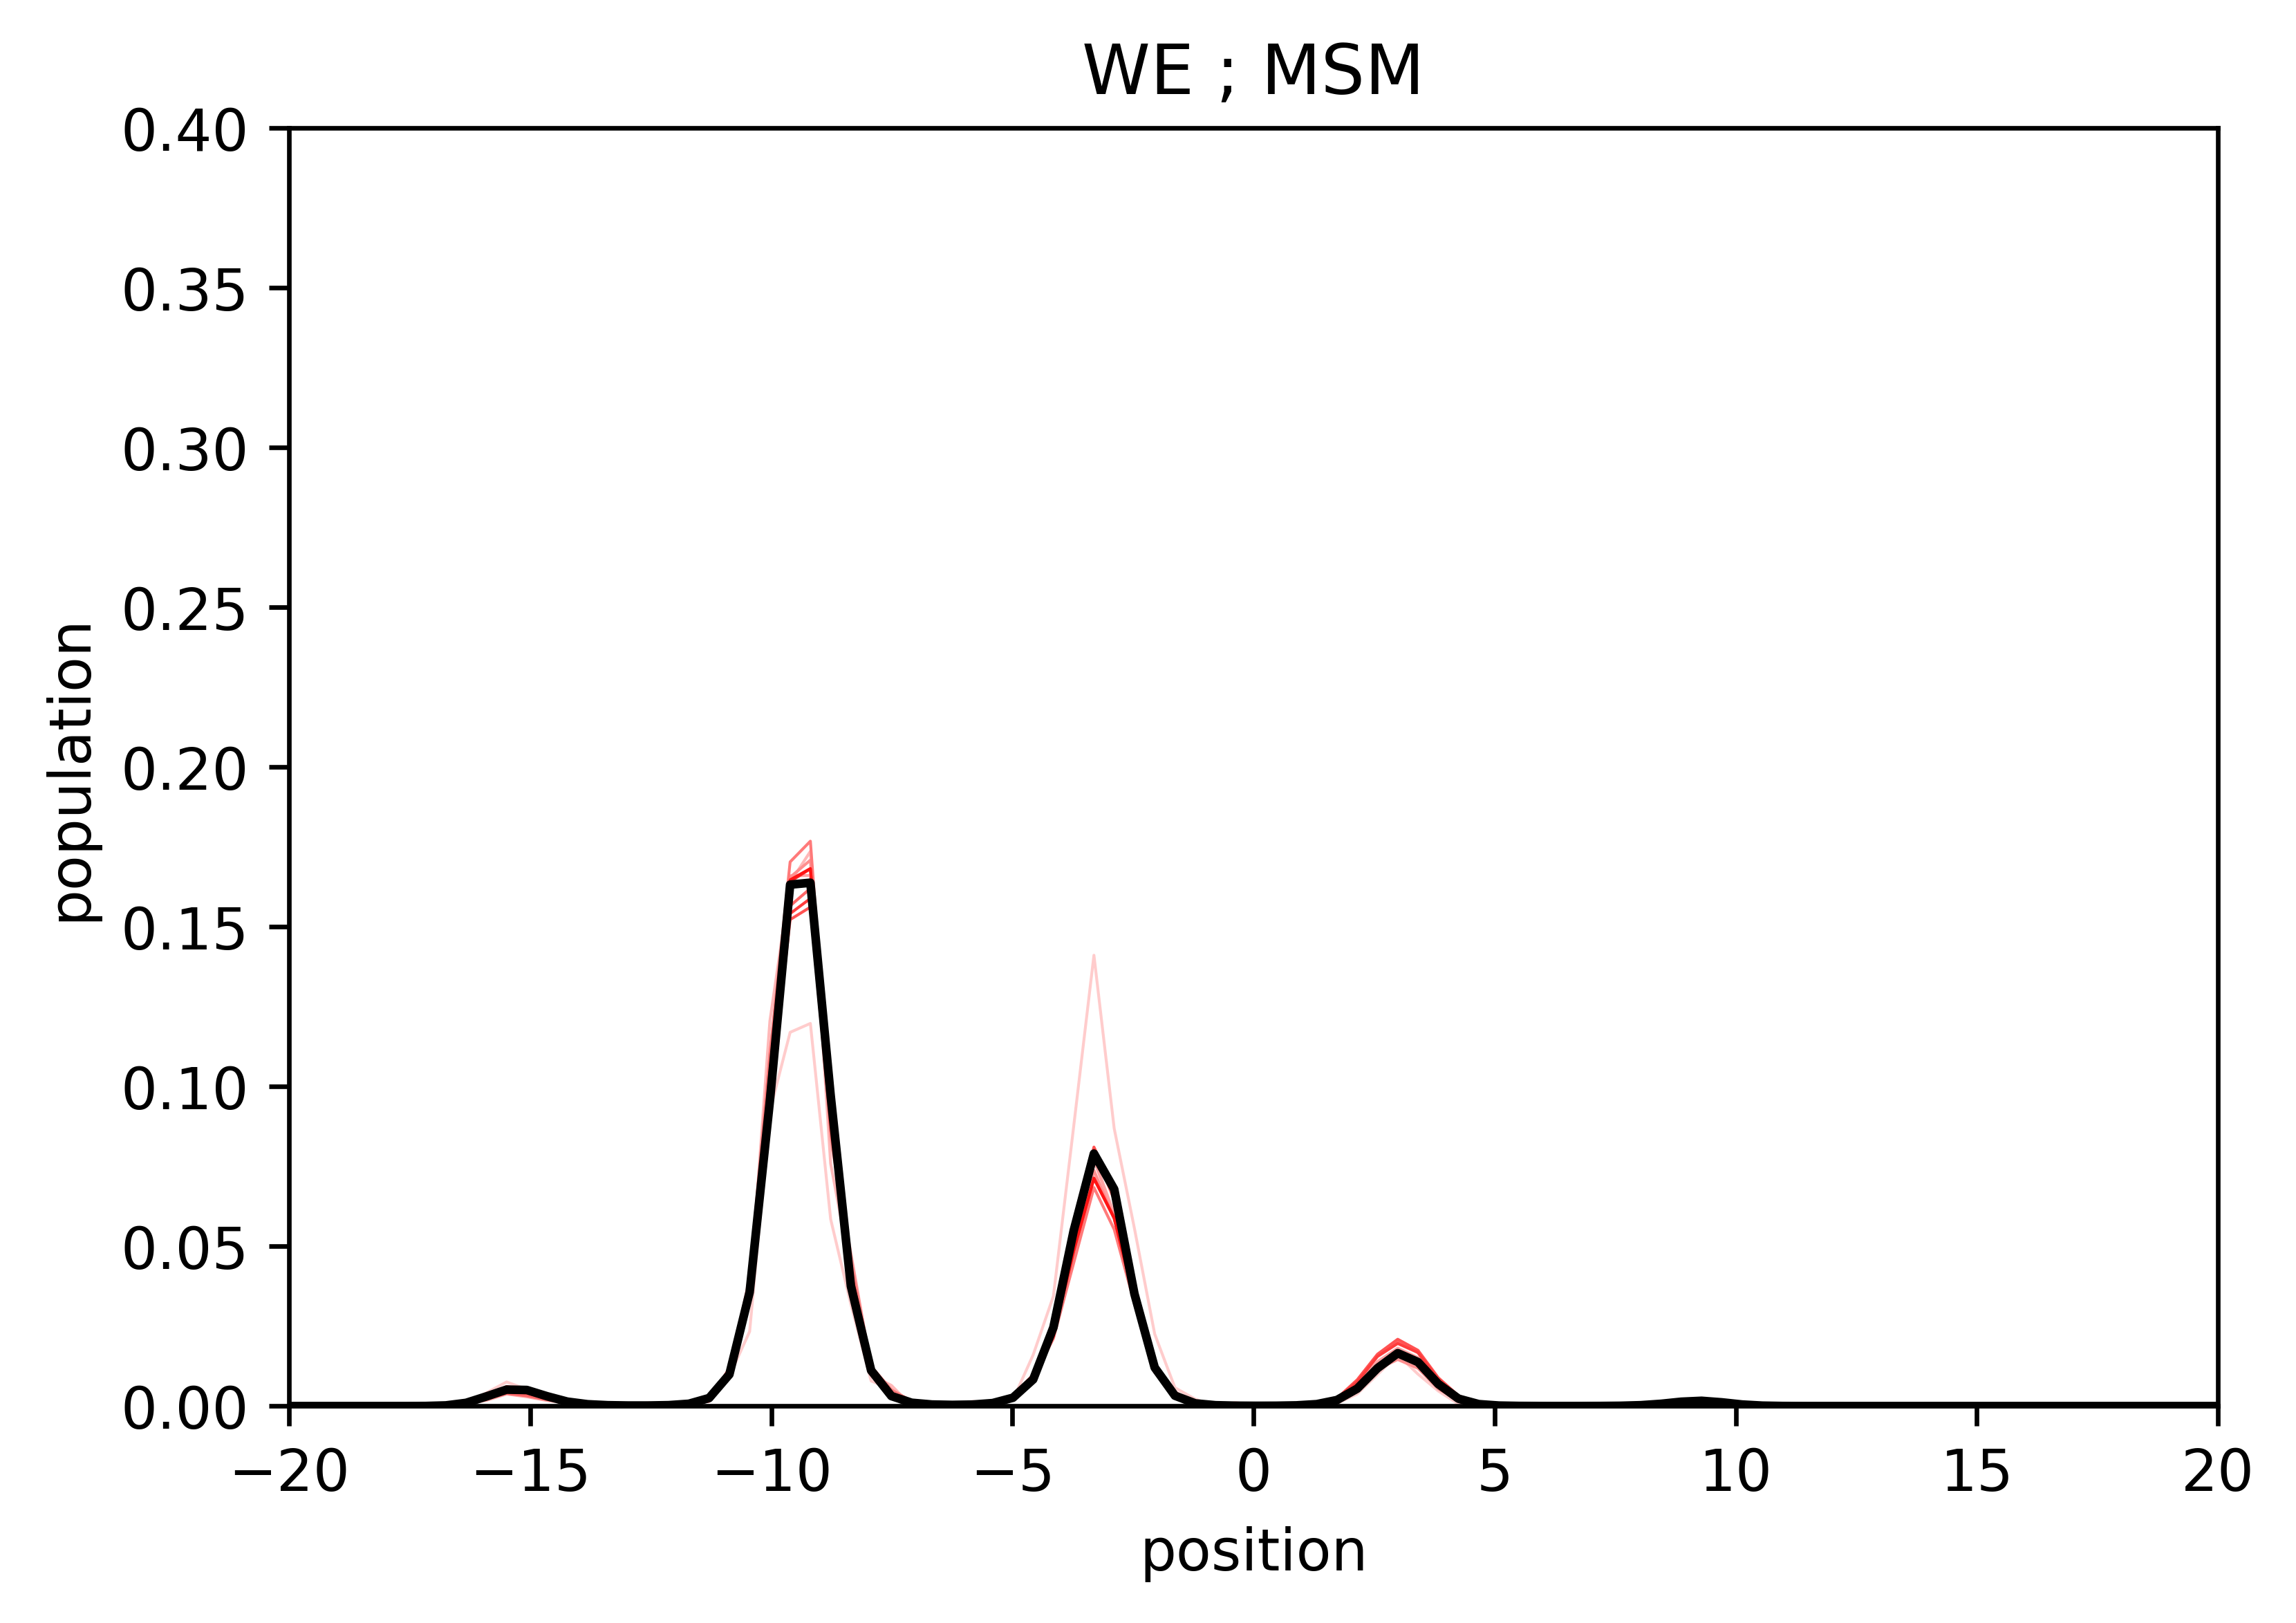

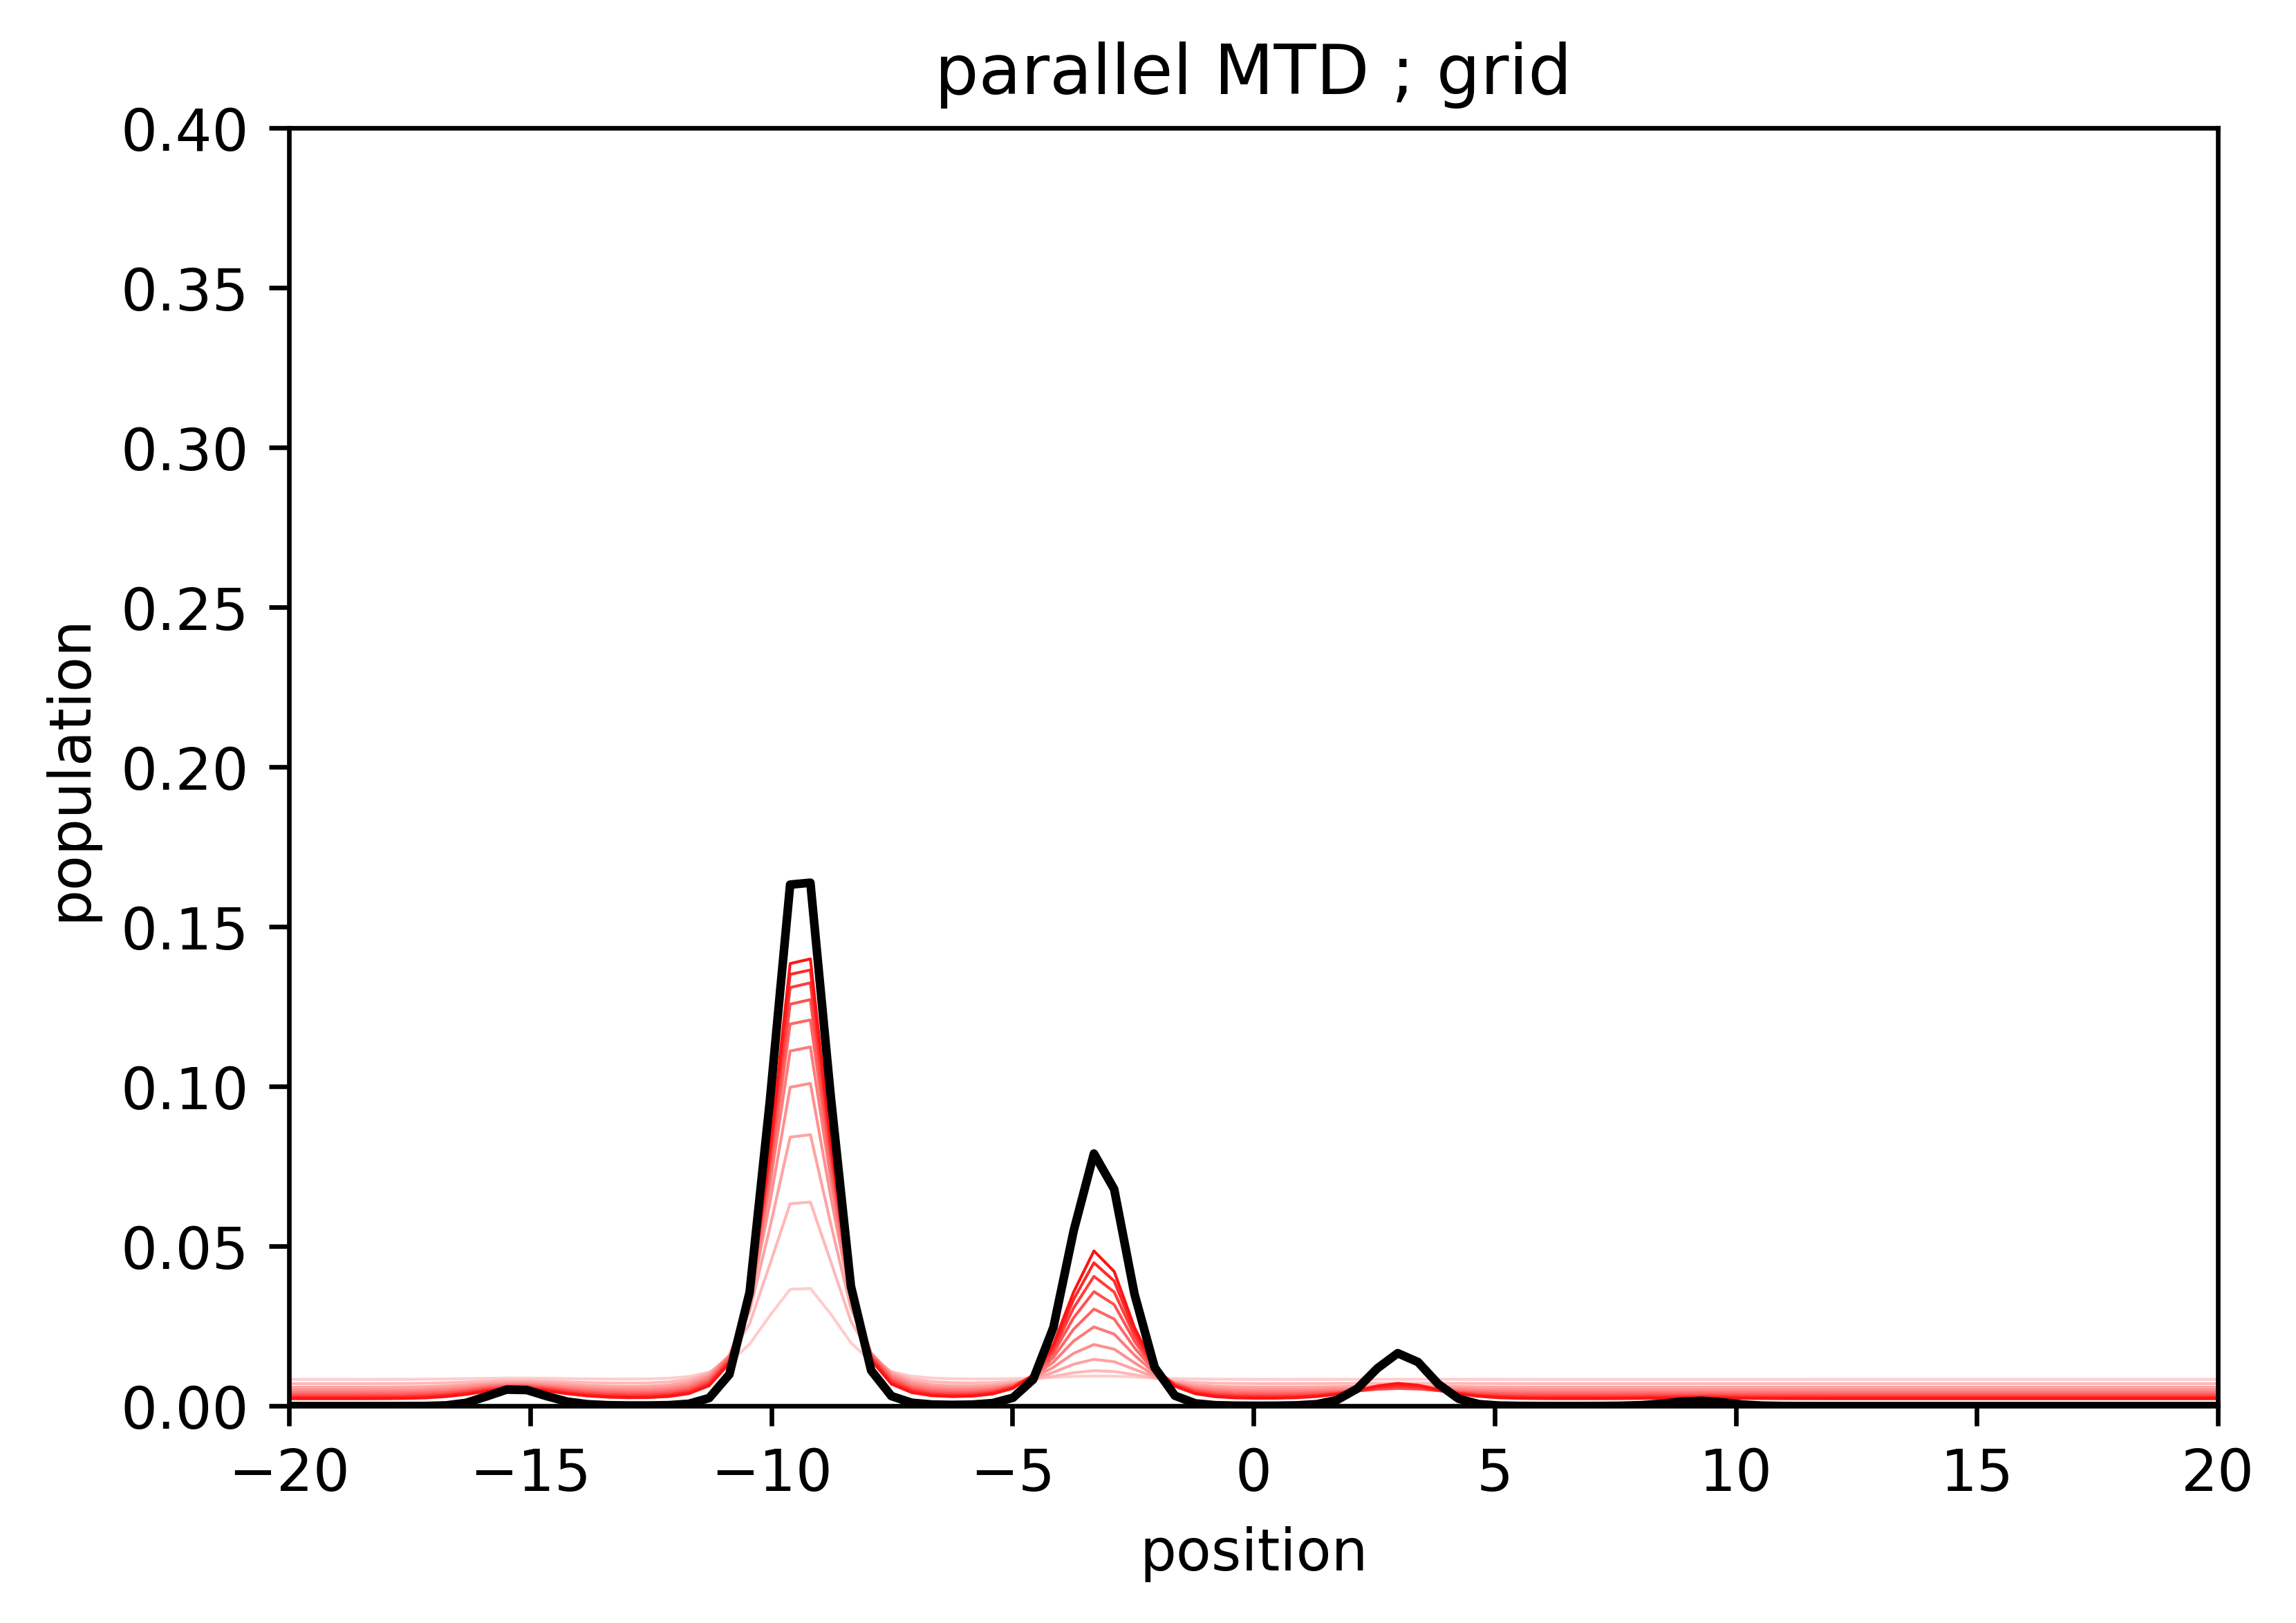

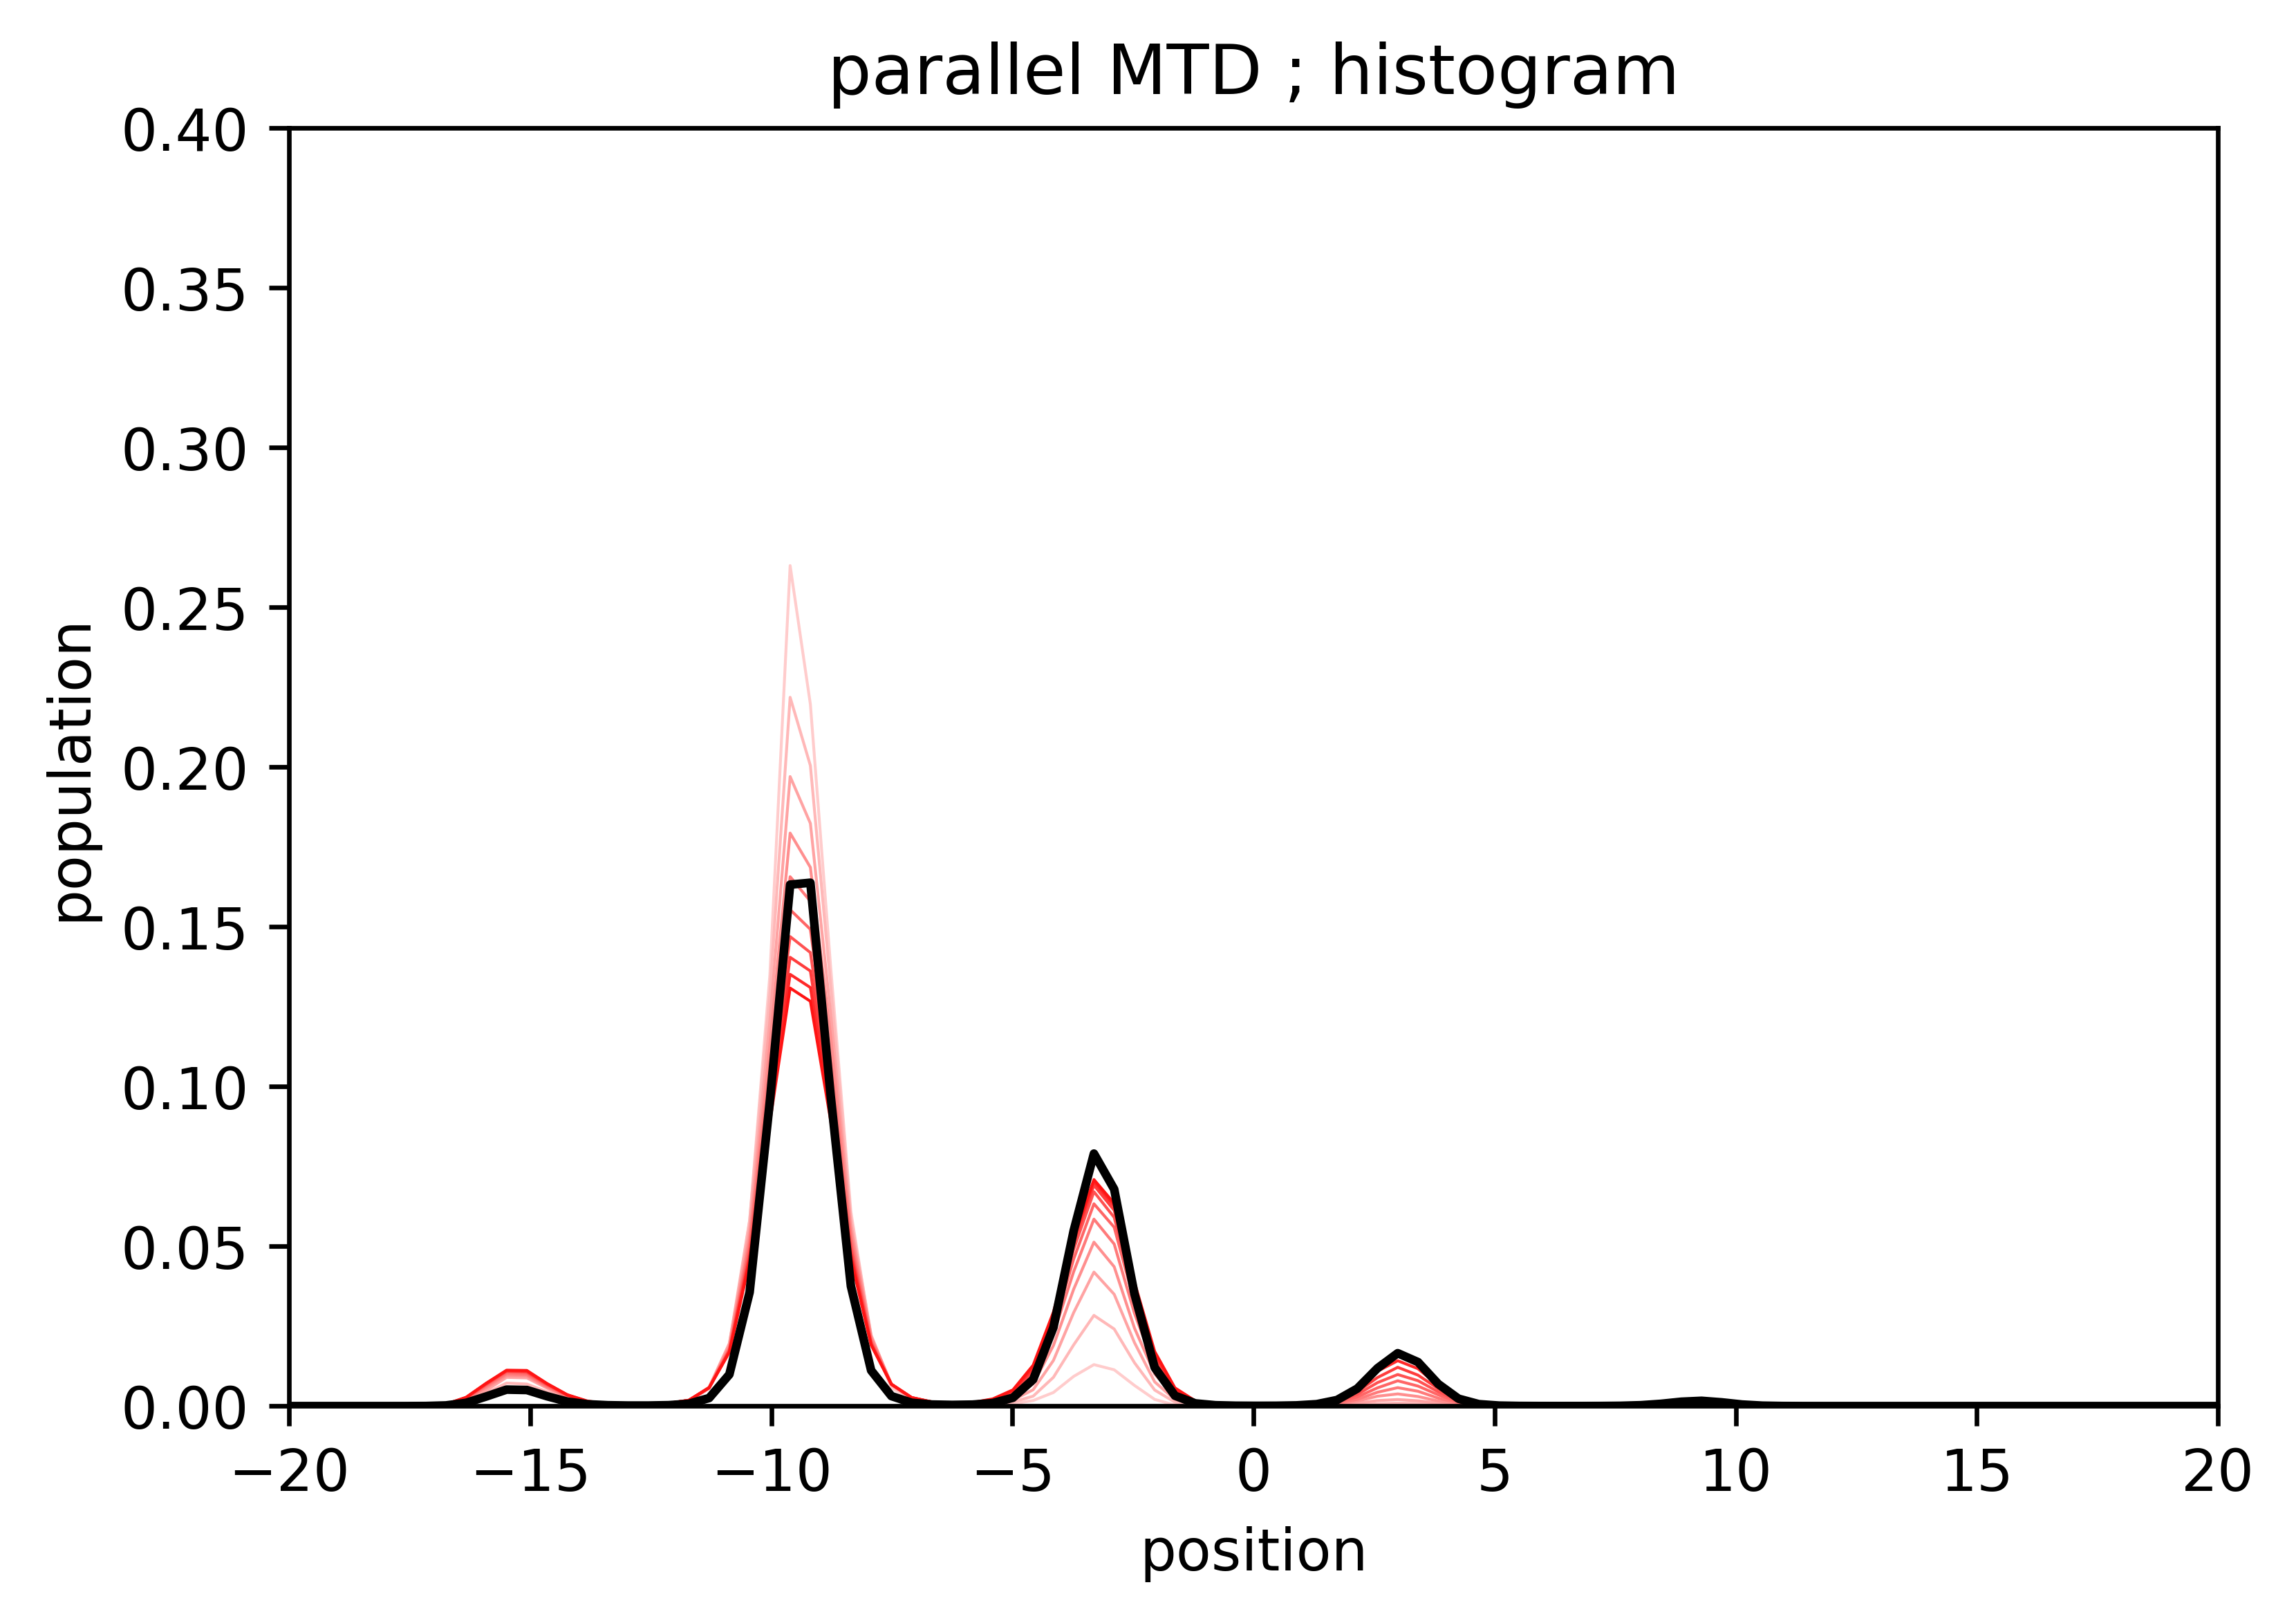

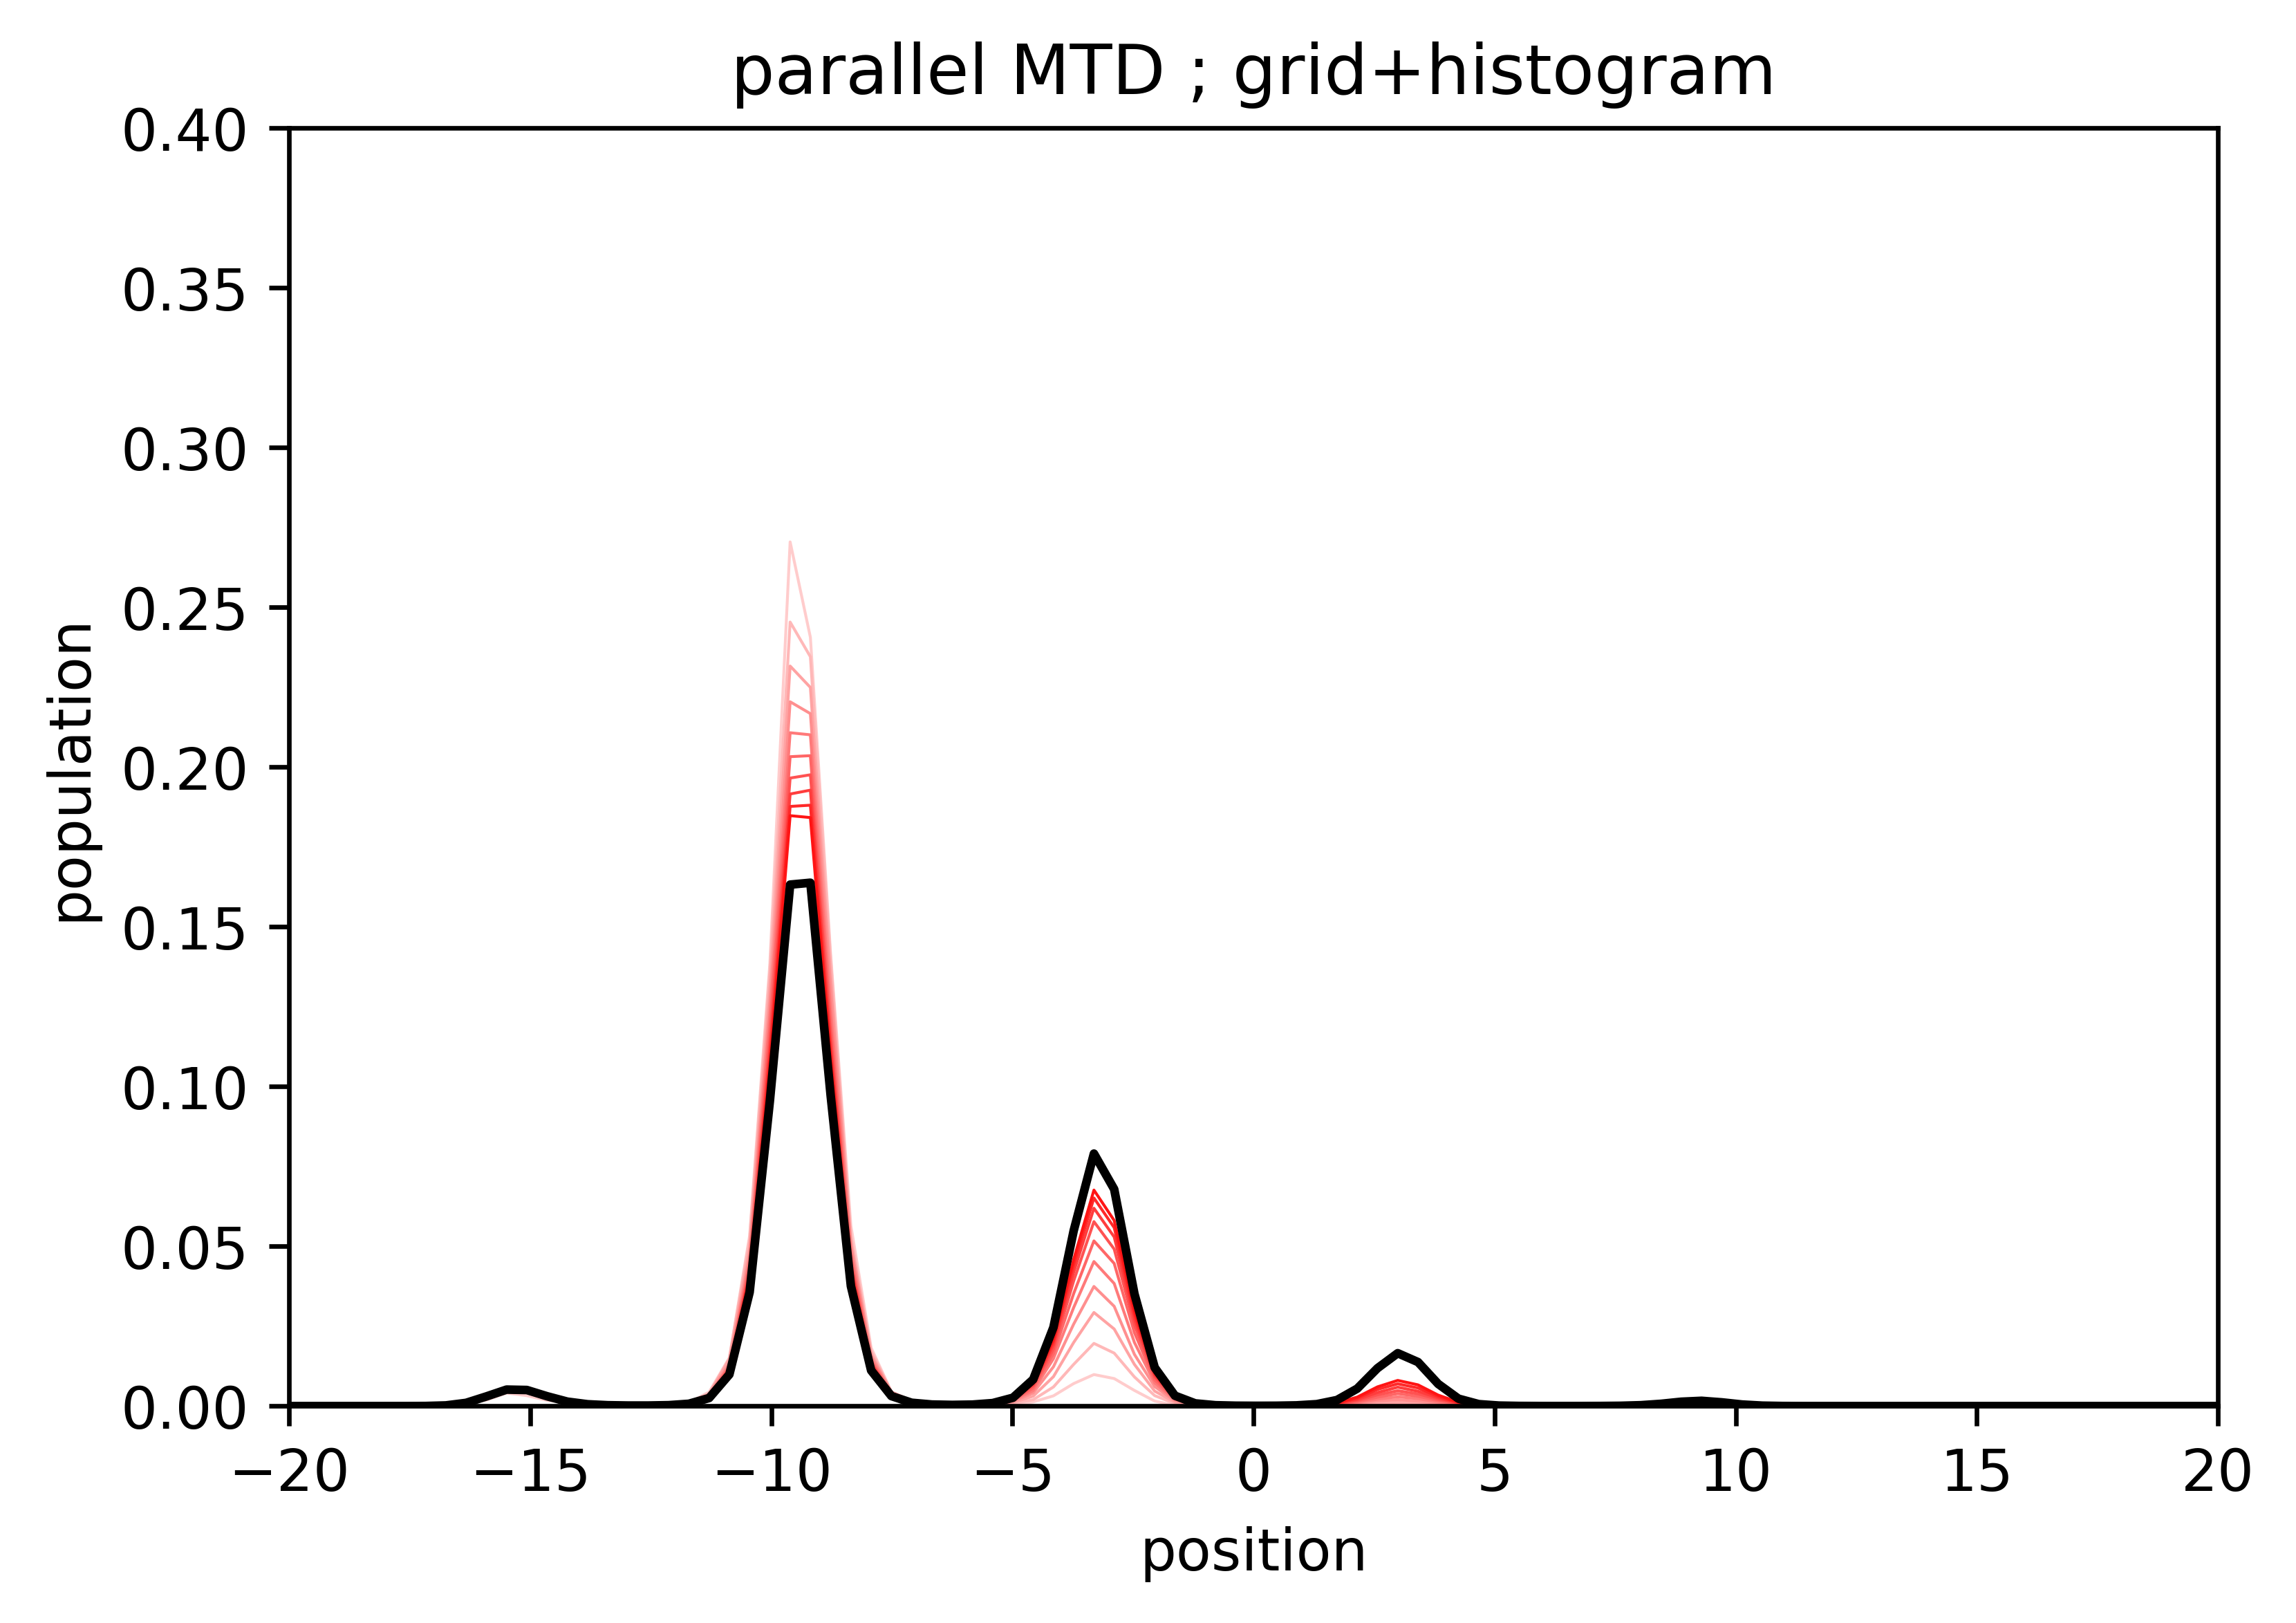

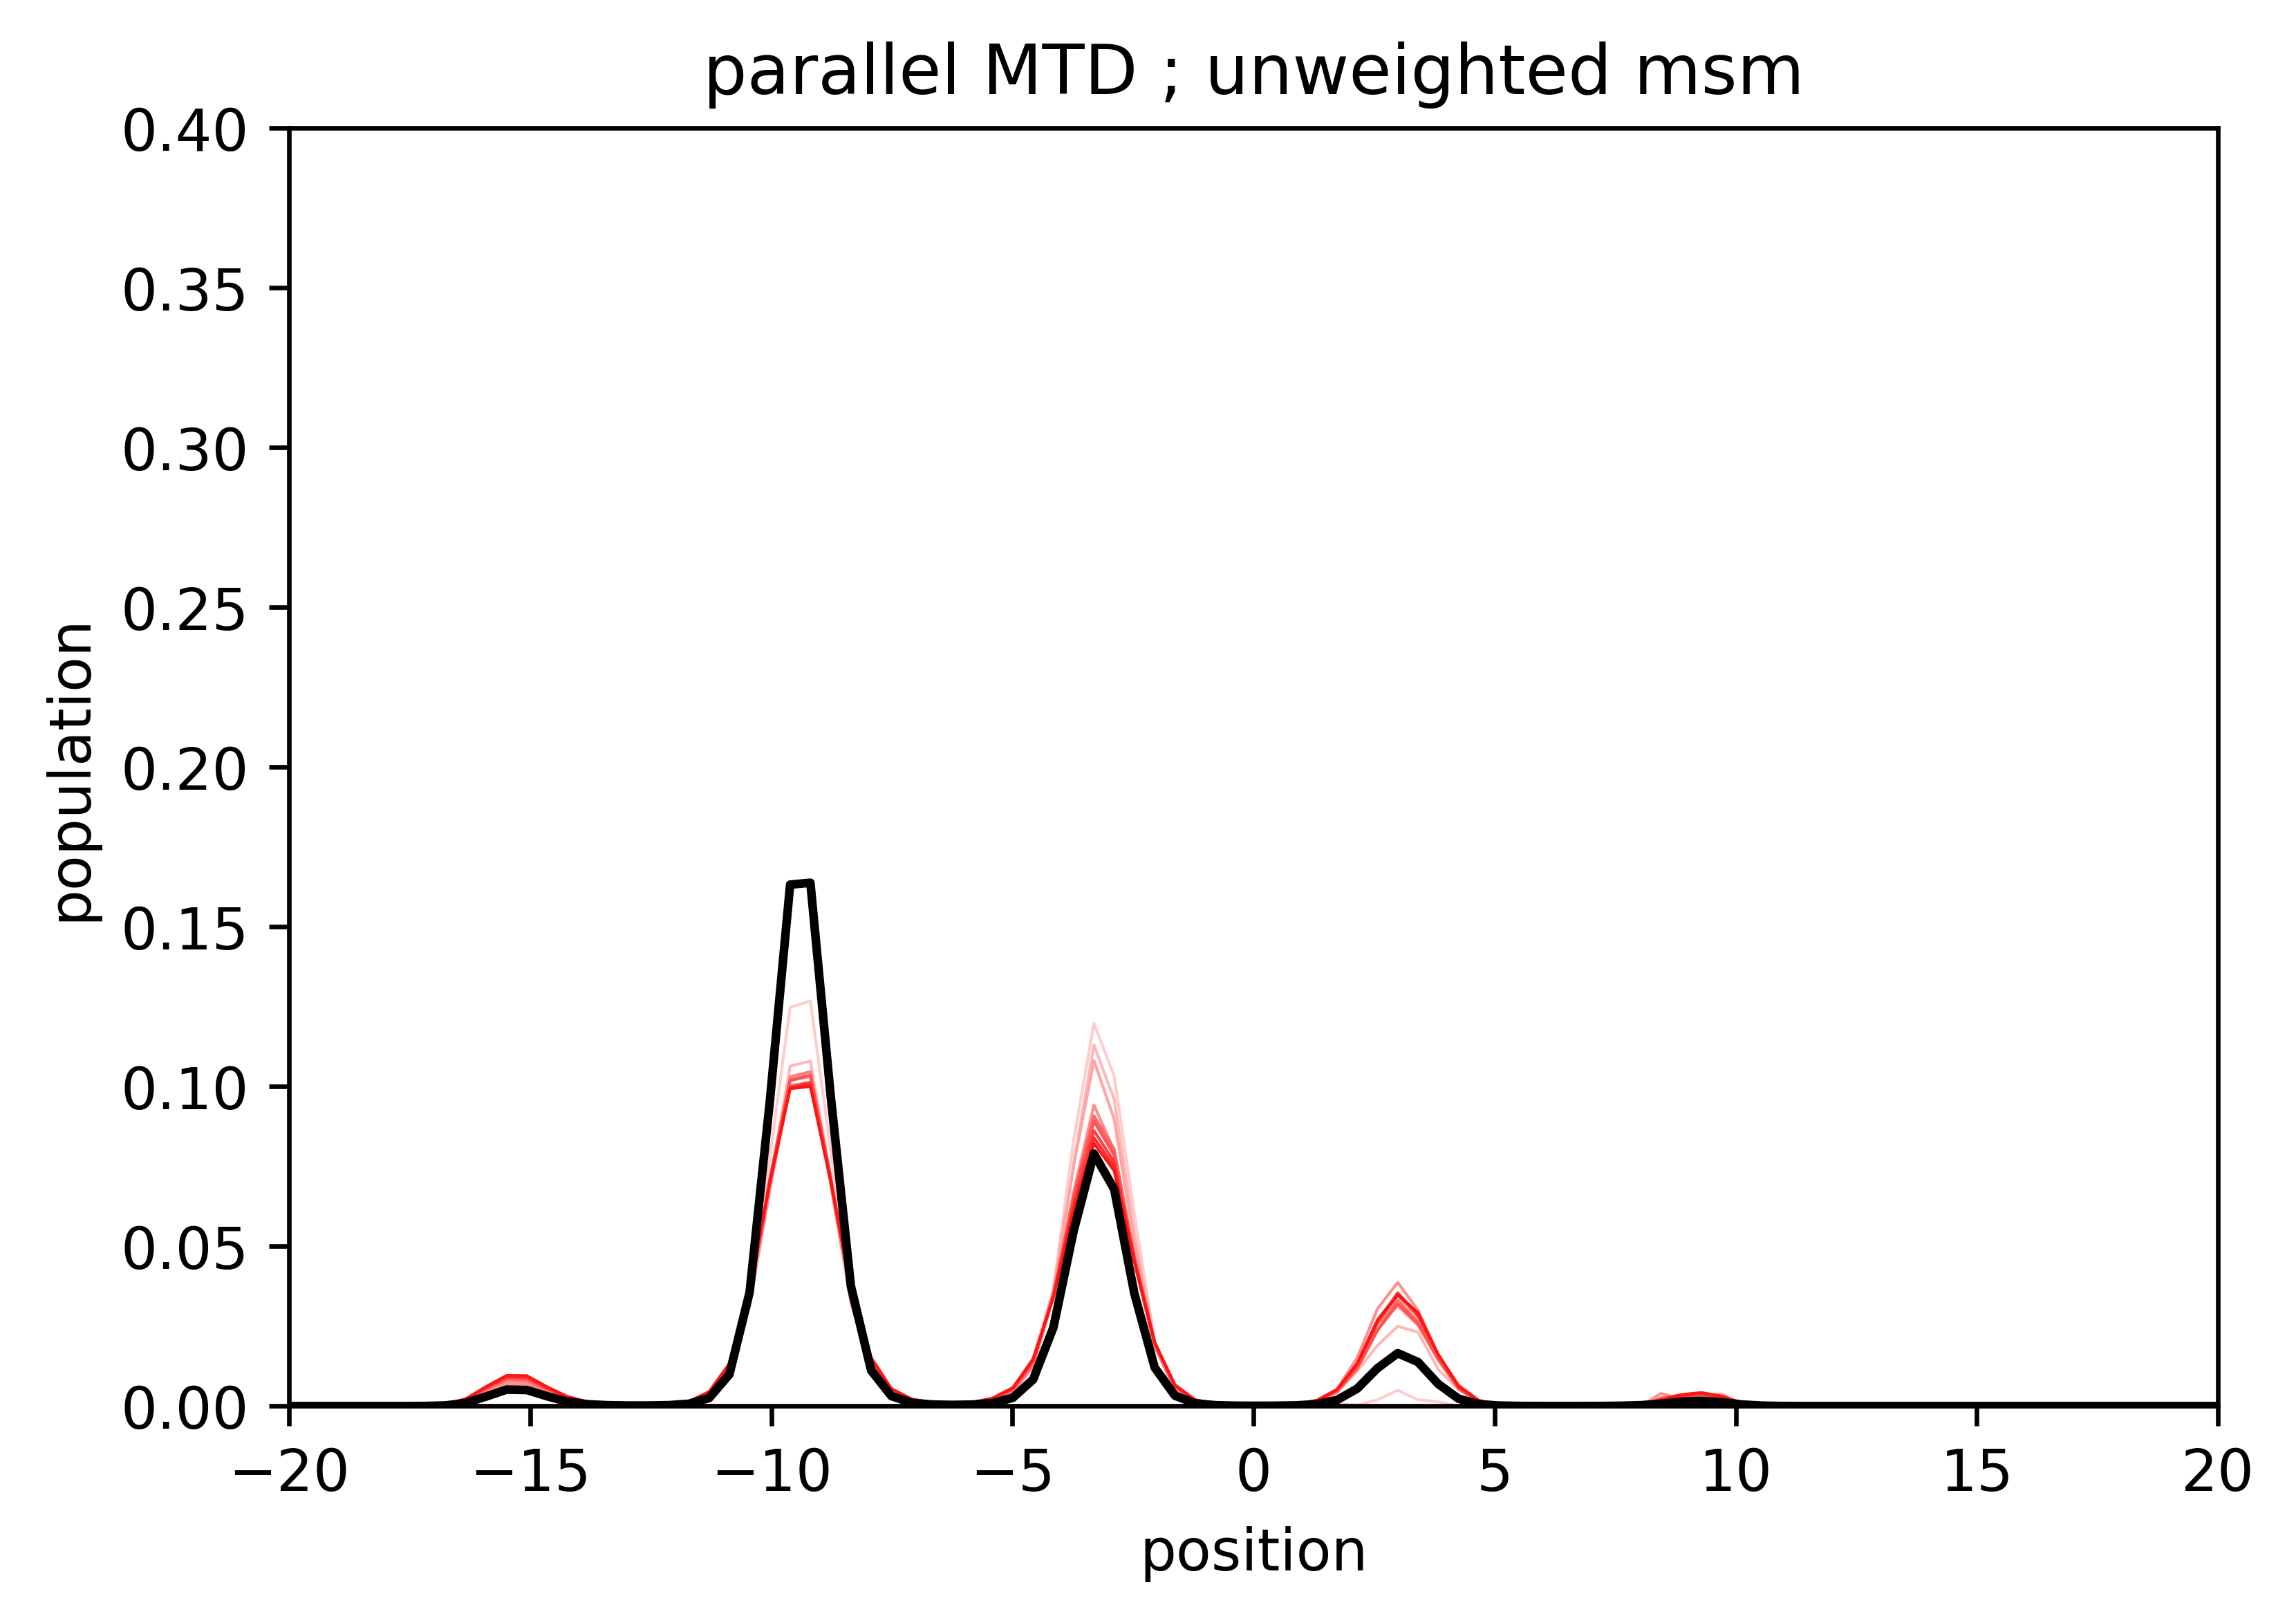

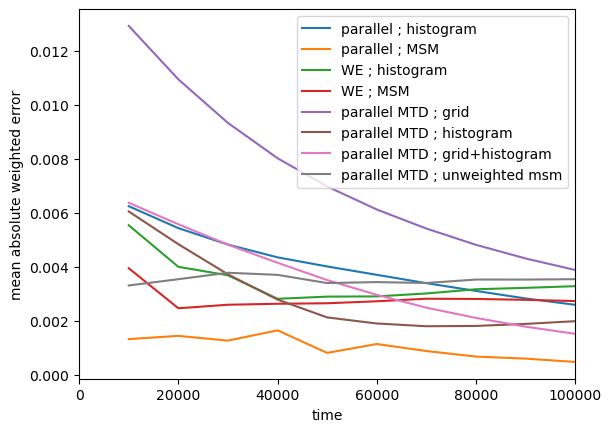

In [ ]:
importlib.reload(utility_v1)
importlib.reload(propagators_v1)
importlib.reload(energy_landscapes_v1)

importlib.reload(parallel_simulations_v1)
importlib.reload(weighted_ensemble_v1)
importlib.reload(metadynamics_v1)
importlib.reload(multiple_walker_metadynamics_v1)

importlib.reload(visualization_v1)

#hyperparameters for estimating convergence
n_timepoints = 10
n_bootstrap = 3

#binning parameters
n_analysis_bins = 100
#save frequency

#simulation time limits (integration steps)
aggregate_simulation_limit = 150000000
#frame_save_limit = 100000
molecular_time_limit = 100000 #20000

#move the number of WE rounds out here; number of data points should be held constant across methods because it reflects lab storage capacity
we_rounds_per_timepoint = 20 #convert to process communication frequency
save_period = int(round(molecular_time_limit/(we_rounds_per_timepoint*n_timepoints))) #in steps

#define bins and calculate the true populations thereof
binbounds, bincenters, step = system1.analysis_bins_1d(n_analysis_bins)
true_populations, true_energies = system1.normalized_pops_energies(kT, bincenters)

#run sampling methods
observables_parallel_mtd = multiple_walker_metadynamics_v1.sampler_parallel_hist_mtd(system1, aggregate_simulation_limit, molecular_time_limit, save_period, n_timepoints, kT, dt, binbounds, bincenters)
observables_parallel = parallel_simulations_v1.sampler_parallel_hist(system1, aggregate_simulation_limit, molecular_time_limit, save_period, n_timepoints, kT, dt, binbounds, bincenters)
observables_we = weighted_ensemble_v1.sampler_we_hist(system1, aggregate_simulation_limit, molecular_time_limit, n_timepoints, we_rounds_per_timepoint, kT, dt, binbounds)

#define which energy landscapes to plot based on the sampling methods and energy landscape estimation methods used
landscape_estimates = [[observables_parallel[0], observables_parallel[1], "parallel ; histogram"], 
                       [observables_parallel[2], observables_parallel[3], "parallel ; MSM"], 
                       [observables_we[0], observables_we[1], "WE ; histogram"], 
                       [observables_we[2], observables_we[3], "WE ; MSM"],
                       [observables_parallel_mtd[0], observables_parallel_mtd[1], "parallel MTD ; grid"],
                       [observables_parallel_mtd[2], observables_parallel_mtd[3], "parallel MTD ; histogram"],
                       [observables_parallel_mtd[4], observables_parallel_mtd[5], "parallel MTD ; grid+histogram"],
                       [observables_parallel_mtd[6], observables_parallel_mtd[7], "parallel MTD ; unweighted msm"]]


#----------------------------------------------------PLOT RESULTS----------------------------------------------------

landscape_estimates_plot = landscape_estimates[:4]

#landscape estimates
for le in landscape_estimates_plot:
    visualization_v1.plot_landscape_estimate(bincenters, le[1], true_populations, le[2], xrange = (-20,20), yrange = (0,0.4))


#convergence over time
for le in landscape_estimates_plot:
    plt.plot([int(round((t+1)*(molecular_time_limit/n_timepoints))) for t in range(len(le[0]))],le[0])

plt.legend([le[2] for le in landscape_estimates_plot])
plt.xlabel("time")
plt.ylabel("mean absolute weighted error")

plt.xlim(0,molecular_time_limit)
#plt.ylim(0,0.1)

plt.show()


In [ ]:

#---------------------------------------------------------------------------------------------------------------------------

# #bin boundaries along each dimension
# binbounds = [np.linspace(system1.standard_analysis_range[0][0], system1.standard_analysis_range[1][0], 14+1),
#              np.linspace(system1.standard_analysis_range[0][1], system1.standard_analysis_range[1][1], 6+1)]

# #get true populations
# state_bins = msm_trj_analysis.bin_to_voxels_msmstates(binbounds, system1.x)
# state_pops = msm_trj_analysis.state_to_bin_populations(state_bins, system1.p)

# #run sampler
# est_state_pop_convergence_we, maew_convergence_we = weighted_ensemble_4.sampler_we_hist(system1, int(nsteps/10), n_timepoints, kT, dt, binbounds)
# est_state_pop_convergence_parallel, maew_convergence_parallel = msm_trj_long_simulation.sampler_parallel_hist(system1, n_parallel, nsteps, save_period, n_timepoints, kT, dt, binbounds)

# #plot results
# for espc in est_state_pop_convergence_parallel:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# #plot results
# for espc in est_state_pop_convergence_we:
#     plt.plot(espc)

# plt.plot(state_pops, color="black")
# plt.show()

# plt.plot(maew_convergence_parallel)
# plt.plot(maew_convergence_we)
# plt.show()